# Linear Regression

This case study is based on code from https://github.com/a-martyn/ISL-python

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML

%matplotlib inline

### Q8. This question involves the use of simple linear regression on the Auto data set.

In [2]:
auto_df = pd.read_csv('auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
auto_df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}

quants = auto_df[datatypes['quant']].astype(np.float_)

auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

#### **(a)** Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output. For example:

- i. Is there a relationship between the predictor and the response?
- ii. How strong is the relationship between the predictor and the response?
- iii. Is the relationship between the predictor and the response positive or negative?
- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [4]:
# Let's start by implementing linear regression from scratch
# using numpy linear algebra

intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})

X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

def linear_model(X, y):
    """Estimation of parameteres for linear regressions model
    by Ordinary Least Squares (OLS)"""
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy     = X.T @ y
    beta    = XTX_inv @ XTy
    return beta

def predict(beta, X):
    """Perdict y given beta parameters and X variables"""
    return X @ beta

beta = linear_model(X, y)
y_pred = predict(beta, X)

In [5]:
# Our handrolled linear model doesn't provide the useful statistics 
# that summary(lm()) would provide in R. 
# For each estimated coefficient we would like to get the follow stats
# - coefficient 
# - standard error
# - t-value
# - p-value

# Add constant for bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})
#Load data
X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

# Predict coefficients and responses
coefficients = linear_model(X, y)
y_pred       = predict(beta, X)


# Calculate Mean Squared Error
MSE = np.sum(np.square(y_pred - y)) / y.size

# Variance of each variable in X
variance = MSE * (np.linalg.inv(X.T @ X).diagonal())  # To discuss: how is variance derived from MSE?

# Standard error of each variable in X
# given by Var(X) = SE(X)^2
standard_error = np.sqrt(variance)

# t-statistic given by t = β - 0 / SE(β)
t_statistic = coefficients / standard_error

# p-values
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))


# Present results
results = pd.DataFrame({'feature': X.columns,
                        'coefficients': coefficients,
                        'standard_error': standard_error,
                        't-statistic': t_statistic,
                        'P>|t|': p_values})

results.set_index('feature')

,coefficients,standard_error,t-statistic,P>|t|
feature,,,,
intercept,39.935861,0.715666,55.802376,0.0
horsepower,-0.157845,0.006429,-24.551848,0.0


In [6]:
# The statsmodels library provides a convenient means to get the
# same statistics

X = auto_df['horsepower']
X = sm.add_constant(X)     # add bias constant
y = auto_df['mpg']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           7.03e-81
Time:                        13:33:59   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

- i. Is there a relationship between the predictor and the response?

> Yes, the low P-value associated with the t-statistic for horsepower suggests so.

- ii. How strong is the relationship between the predictor and the response?

> For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg. 

- iii. Is the relationship between the predictor and the response positive or negative?

> Negative

- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [7]:
# predicted mpg associated with a horsepower of 98

def predict(model, X):
    return model.T @ X

X_ex = np.array([1, 98])

y_ex = predict(coefficients, X_ex)
print(str(np.round(y_ex, 3)) + ' mpg')

24.467 mpg


In [8]:
# the associated 95% confidence and prediction intervals

model_min = results.conf_int(alpha=0.05)[0]
model_max = results.conf_int(alpha=0.05)[1]

confidence_interval = [predict(model_min, X_ex), predict(model_max, X_ex)]
print(confidence_interval)

[21.814544959722646, 27.119609345302205]


#### **(b)** Plot the response and the predictor. Use the abline() function to display the least squares regression line.

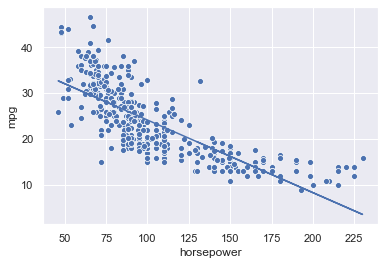

In [9]:
# Let's plot our predicted regression

df = pd.concat([auto_df['horsepower'], auto_df['mpg']], axis=1)
ax = sns.scatterplot(x='horsepower', y='mpg', data=df)
ax.plot(auto_df['horsepower'], y_pred);

#### **(c)** Use the plot() function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

In [10]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_stats1(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.dot(np.dot(X, np.linalg.inv(np.dot(X.T, X))), X.T)
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');


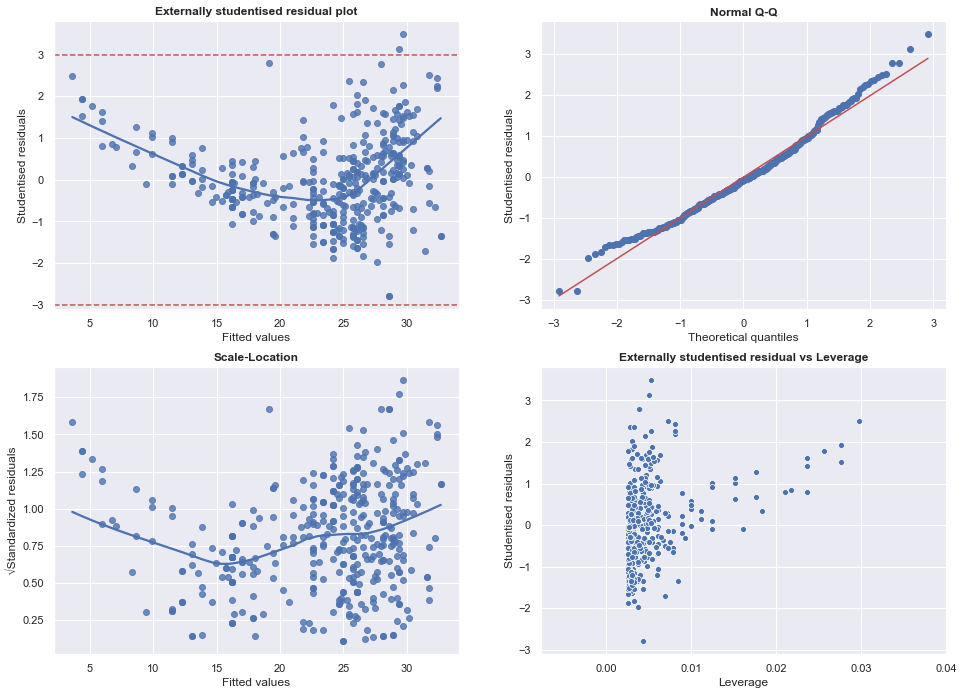

In [11]:
X = pd.concat([auto_df['horsepower']], axis=1)
# Create the Design Matrix by adding constant bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(X.shape[0])})
X = np.array(pd.concat([intercept_const, X], axis=1))

y = auto_df['mpg']

lm_plot(lm_stats1(X, y, y_pred))

The above residual plot grid shows the relationship between the horsepower predictor and the mpg response. There are several things to note:

- **Non-linearity of the data:** The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.
- **Heteroscedasticity – Non-constant variance of error terms** The top-left residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by *weighted least squares*.
- **Outliers and leverage:** the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.
- The top-right plot shows that our studentised residuals have a slightly non-normal distribution (TODO: ellaborate)



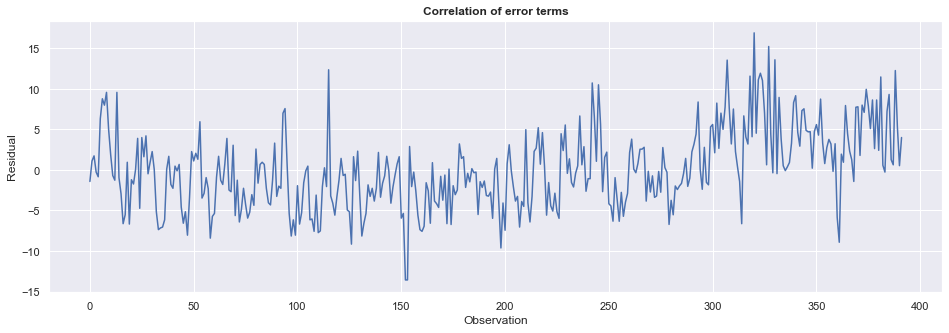

In [12]:
def lm_residual_corr_plot(lm_stats_df):
    r = lm_stats_df['residual']
    # Residuals correlation
    plt.figure(1, figsize=(16, 5))
    ax = sns.lineplot(x=list(range(r.shape[0])), y=r)
    plt.xlabel('Observation')
    plt.ylabel('Residual')
    plt.title('Correlation of error terms', fontweight='bold');  

lm_residual_corr_plot(lm_stats(X, y, y_pred))

- **Correlation of error terms:** The Correlation of Error Terms plot shows errors against ordered observations in our dataset. We see a slight increase in error above the 300th observation suggesting some correlation effect. This could mean that our estimated standard errors underestimate the true standard errors. Our confidence and prediction intervals may be narrower than they should be.

### 9. This question involves the use of multiple linear regression on the Auto data set.

#### **(a)** Produce a scatterplot matrix which includes all of the variables in the data set.

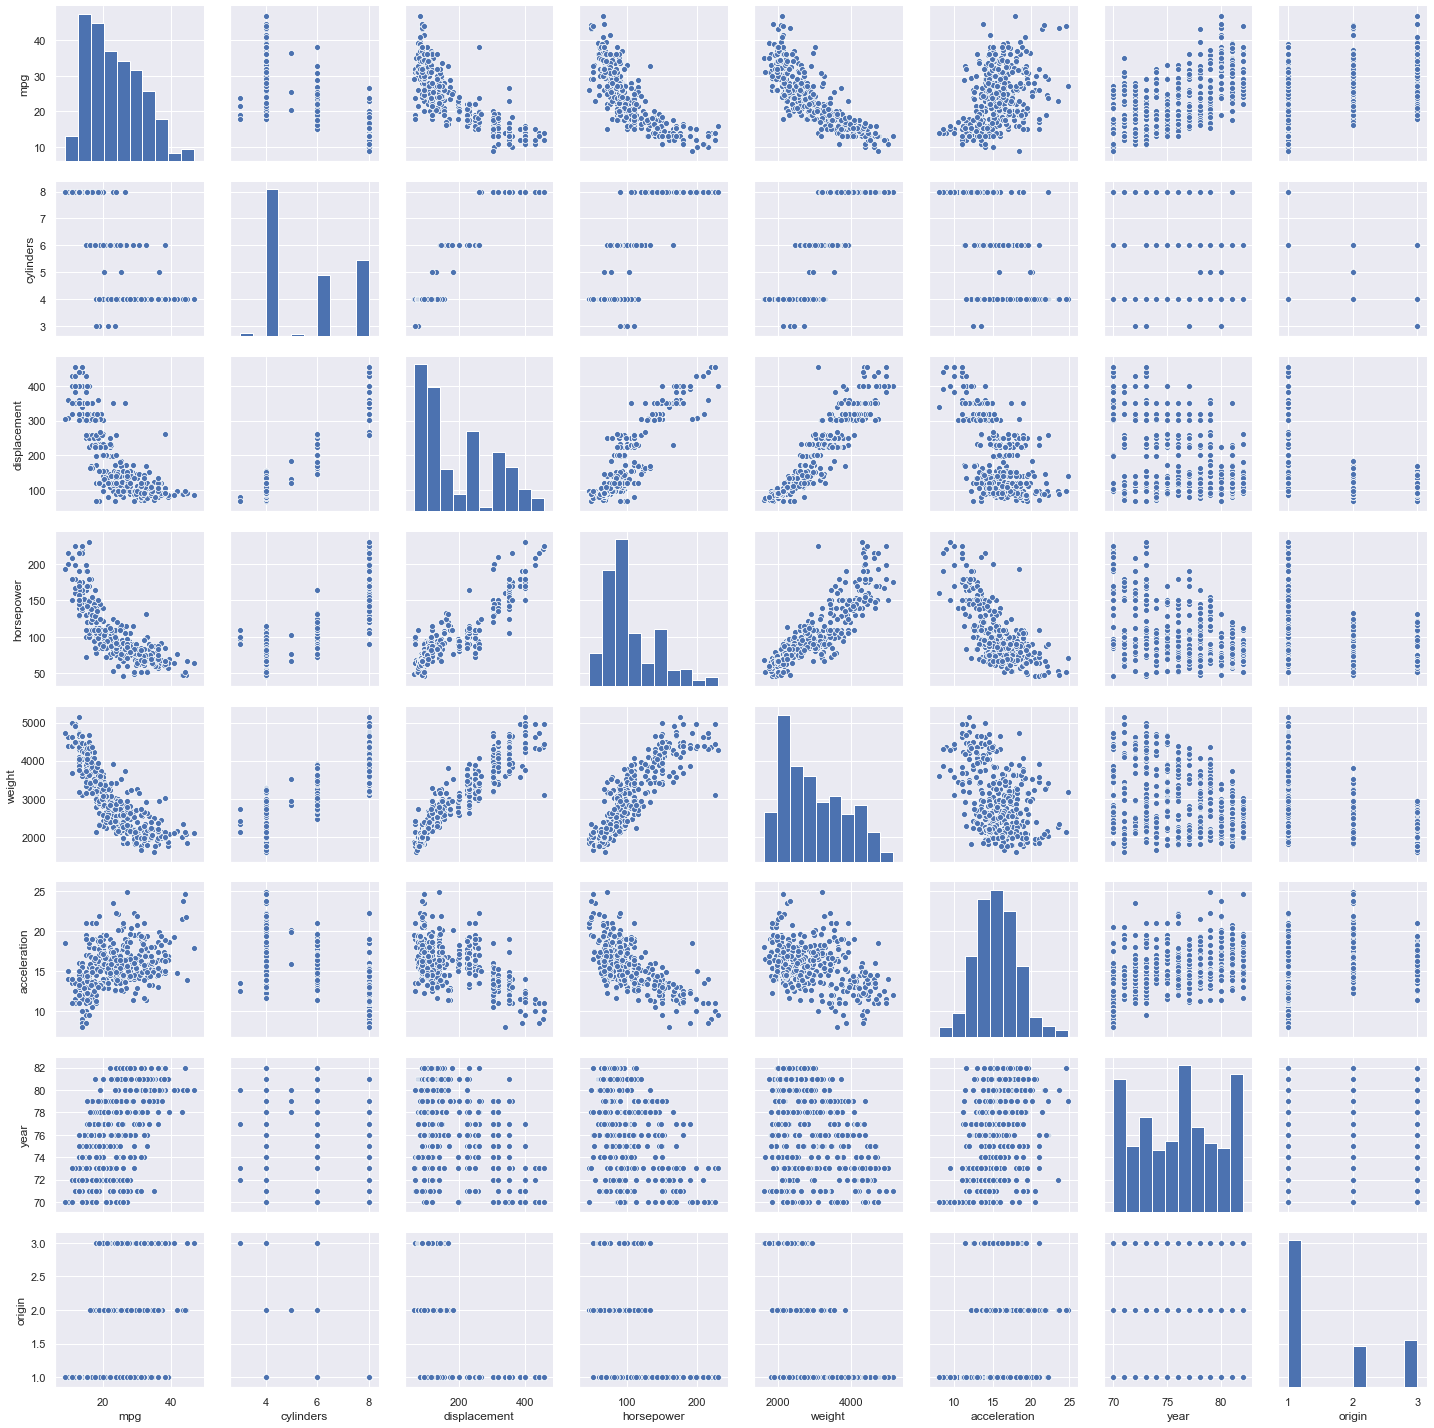

In [13]:
sns.pairplot(auto_df);

#### **(b)** Compute the matrix of correlations between the variables using the function cor(). You will need to exclude the name variable, which is qualitative.

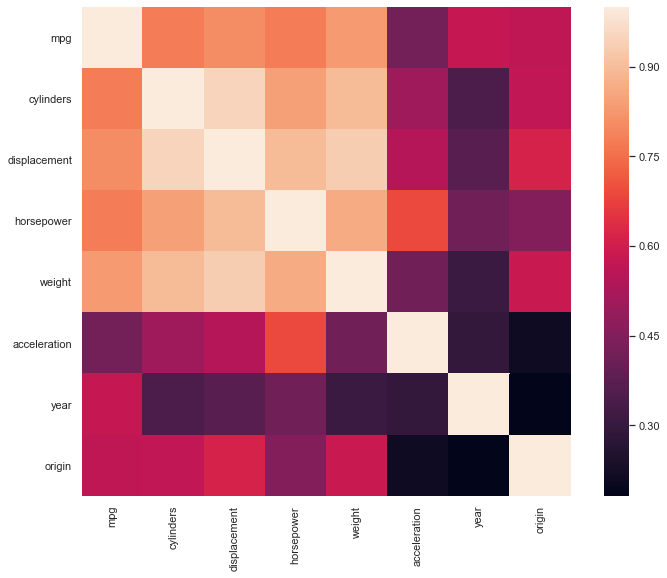

In [14]:
corr_matrix = auto_df.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

#### (c) Perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results. Comment on the output. For instance:

1. Is there a relationship between the predictors and the response?
2. Which predictors appear to have a statistically significant relationship to the response?
3. What does the coefficient for the year variable suggest?

In [15]:
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          1.79e-139
Time:                        13:44:53   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.

In [16]:
# The following predictors have P-values < 0.05 which suggests we can reject 
# the null hypothesis that they have no relationship with the response:
model.pvalues[model.pvalues < 0.05].sort_values()

year              2.332943e-40
weight            6.375633e-22
C(origin)[T.3]    3.933208e-07
C(origin)[T.2]    4.720373e-06
Intercept         1.445124e-04
displacement      1.862685e-03
dtype: float64

The coefficient for the `year` variable suggests that there is a positive relationship between `year` and `mpg` – the response variable increases as year increases. Specifically, this suggessts that cars manufactured more recently tend to be more fuel efficient and that all else being equal efficiency increases by 0.75 mpg/year. 


#### (d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

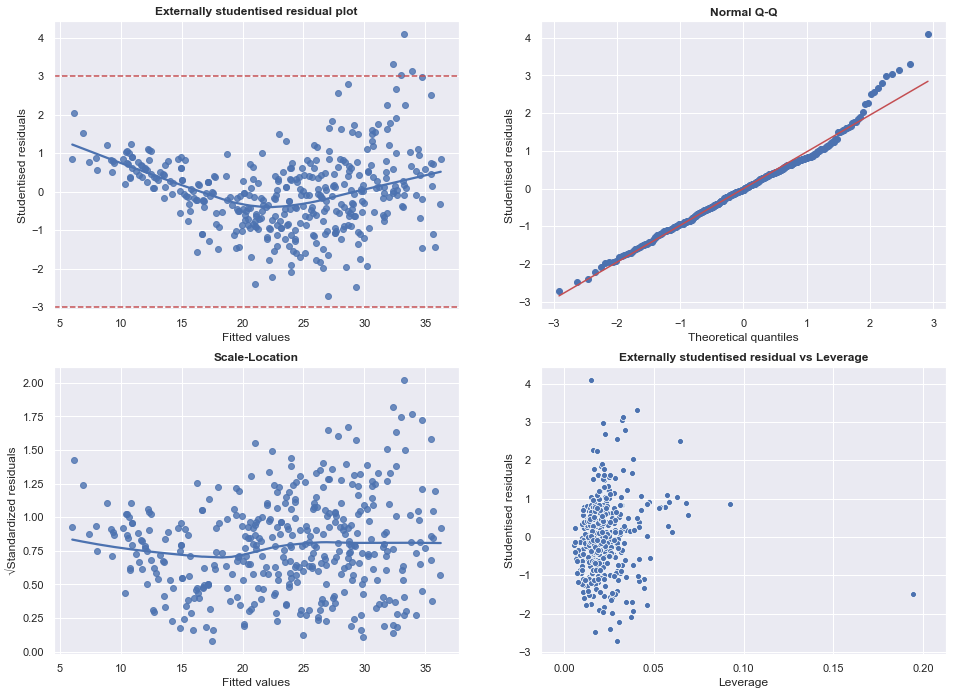

In [17]:
# Make predictions
y_pred = np.array(model.predict(X))

# Analyse residuals
lm_plot(lm_stats1(X, y, y_pred))

- **Linearity:** The u-shaped pattern in the top-left residual plot suggests that there a non-linear relationship that our model is unable to account for. The bottom left Scale-Location plot suggests that a square-root transform reduces the non-linearity of this relationship allowing our model to achieve an improved fit.
- **Heteroscedasticity:** A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.
- **Outliers:** The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.
- **Leverage:** The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.
- **Normality:** The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates `mpg` for a larger number of observations than we might expect assuming a normal distribution.



#### (e) Use the * and : symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?

In [18]:
# Let's fit a model with all possible interaction effects

f = 'np.log1p(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year \
    '

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log1p(mpg)   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     152.3
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          2.31e-172
Time:                        13:45:01   Log-Likelihood:                 346.65
No. Observations:                 392   AIC:                            -645.3
Df Residuals:                     368   BIC:                            -550.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [19]:
# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
model.pvalues[model.pvalues < 0.05].sort_values()

cylinders:displacement    0.009575
acceleration              0.009944
acceleration:year         0.011091
displacement:year         0.017965
Intercept                 0.048352
dtype: float64

Only the above features seem to be statistically significant in this model.

Notice the warning (2) that suggests the might be multicollinearity in this model. We can observe in the correlation plot above that there is strong collinearity between mpg, cylinders, displacement, horespower, and weight. This means further investigation is required to discern which, if any, of these features have a *causal* relationship with our response `mpg`.  

#### (f) Try a few different transformations of the variables, such as log(X), √X, X2. Comment on your findings.

Let's start by taking log of the response variable only.

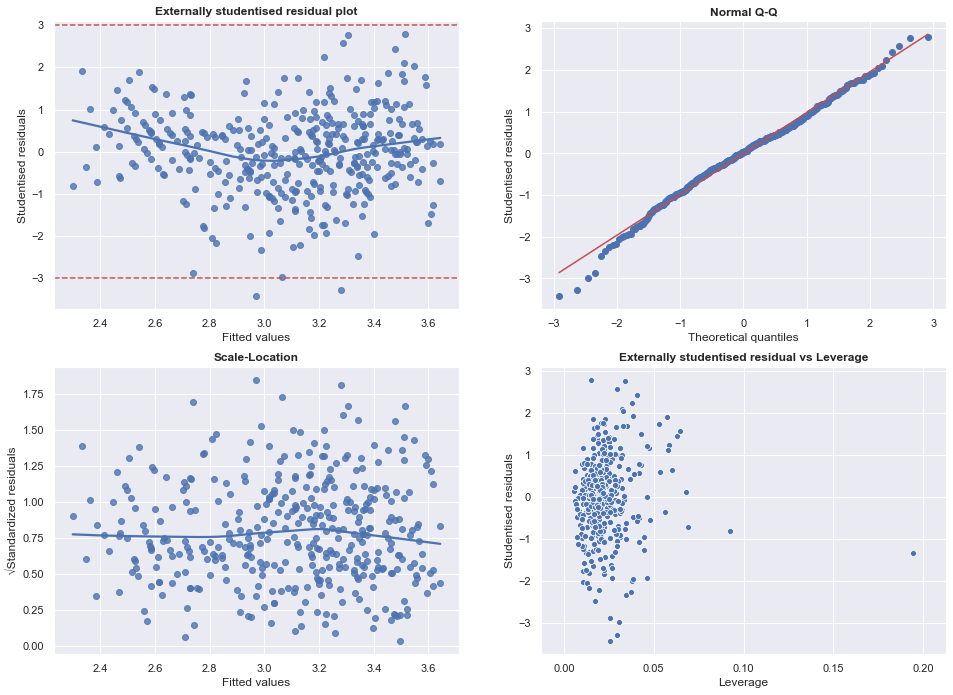

In [20]:
# Note: taking log of response variable to normalise distribution
f = 'np.log(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()

# Make predictions
y_pred = np.array(model.predict(X))

# Analyse residuals
lm_plot(lm_stats1(X, y, y_pred))

**Comment:** Taking the log of the response variable dramatically improves aspects of our diagnostic plots.

- there is less pattern in the left-hand residual plots suggesting the log transform of `mpg` as decreased the non-linearity of its relationship to features and so improved our models ability to fit the date.
- there is a reduction in the conic shape of the bottom left plot suggesting a reduction in homoscedasticity
- the top-right plot suggests the model is now inclined to overstimate instead of underestimate
- there are no-longer any outliers exceeding a studentised residual value of three. there are now two outliers <-3


**Question:** What if we take logs of all our predictor variables also?

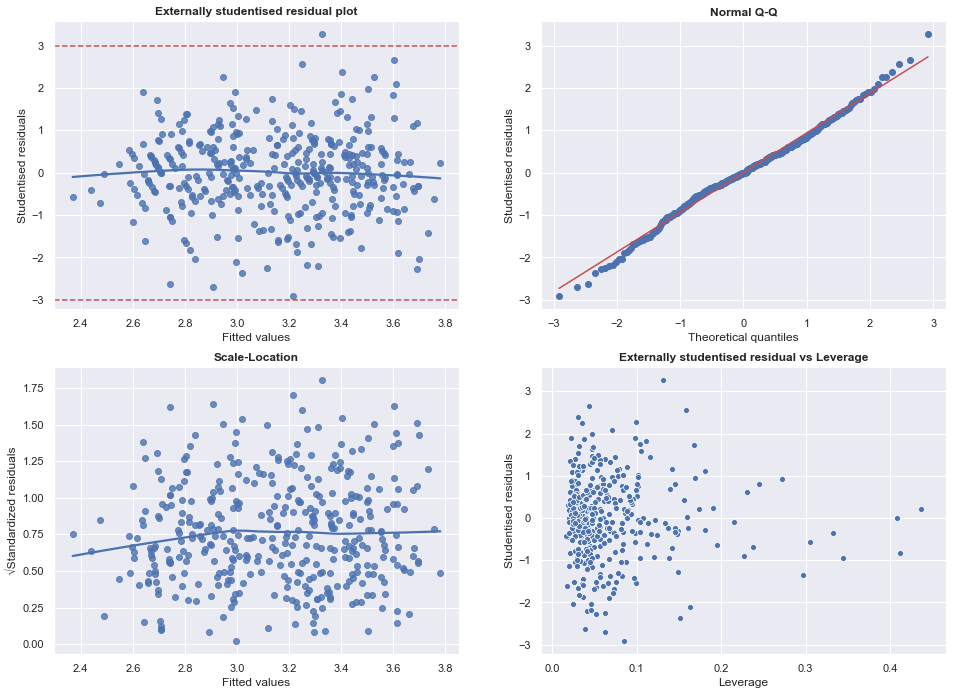

In [21]:
f = 'np.log1p(mpg) \
    ~ np.log1p(cylinders) \
    + np.log1p(displacement) \
    + np.log1p(horsepower) \
    + np.log1p(weight) \
    + np.log1p(acceleration) \
    + np.log1p(year) \
    + C(origin) \
    + np.log1p(cylinders*displacement) \
    + np.log1p(cylinders*horsepower) \
    + np.log1p(cylinders*weight) \
    + np.log1p(cylinders*acceleration) \
    + np.log1p(cylinders*year) \
    + np.log1p(displacement*horsepower) \
    + np.log1p(displacement*weight) \
    + np.log1p(displacement*acceleration) \
    + np.log1p(displacement*year) \
    + np.log1p(horsepower*weight) \
    + np.log1p(horsepower*acceleration) \
    + np.log1p(horsepower*year) \
    + np.log1p(weight*weight) \
    + np.log1p(weight*acceleration) \
    + np.log1p(weight*year) \
    + np.log1p(acceleration*year) \
    '

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')
model = sm.OLS(y, X).fit()
#print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

# Analyse residuals
lm_plot(lm_stats1(X, y, y_pred))



In [22]:
# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
model.pvalues[model.pvalues < 0.05].sort_values()

np.log1p(cylinders * displacement)     5.450938e-07
np.log1p(year)                         3.554276e-06
Intercept                              4.103286e-06
np.log1p(horsepower * acceleration)    4.088496e-04
np.log1p(cylinders * acceleration)     5.328883e-03
np.log1p(horsepower * weight)          1.089279e-02
np.log1p(horsepower * year)            2.345207e-02
np.log1p(displacement)                 3.208041e-02
np.log1p(cylinders * horsepower)       4.141974e-02
dtype: float64

**Comment:** Comparing the above diagnostics grid with the preceding grid suggests that taking log of predictors has further reduced the non-linearities in our dataset. 

The number of observations that appear as outliers has reduced from two to one. Heteroscedasticity has also been reduced. The distribtuion of studentised residuals is more normal.

There is notably increased variance in the leverage of our observations.

**Question:** what if we only use the features from this model with p-values < 0.05?


In [23]:
# Let's use just the most significant features from the set of all log features
significant_features = model.pvalues[model.pvalues < 0.05].drop('Intercept').index
f = 'np.log(mpg) ~ ' + ' + '.join(list(significant_features))

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()

# Make predictions
y_pred = np.array(model.predict(X))

# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
print(model.summary())

# Analyse residuals
lm_plot(lm_stats(X, y, y_pred))

                            OLS Regression Results                            
Dep. Variable:            np.log(mpg)   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     394.3
Date:                Tue, 13 Oct 2020   Prob (F-statistic):          1.11e-179
Time:                        13:45:14   Log-Likelihood:                 302.85
No. Observations:                 392   AIC:                            -587.7
Df Residuals:                     383   BIC:                            -552.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

ValueError: Shape of passed values is (392, 392), indices imply (392, 9)